In [262]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [263]:
import wntr
import pandas as pd
import numpy as np
import copy
import networkx as nx
import torch
from wntr.graphics import plot_network
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from IPython.display import display, Markdown
from itertools import product


In [264]:
inp_file = 'tsnet.inp'

### Network Topology Without Leak Junctions

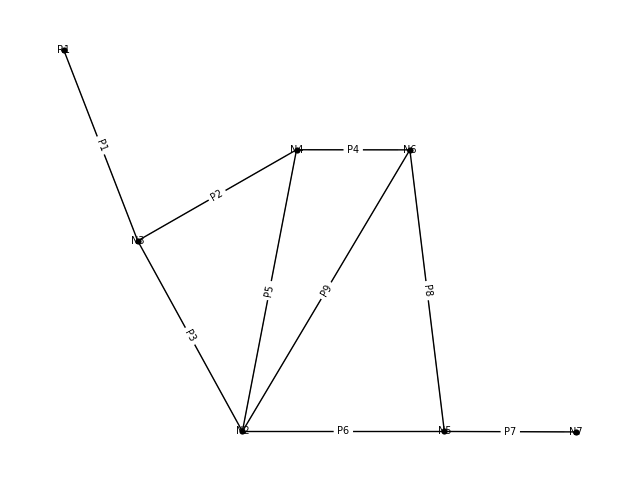

In [265]:
# Plot just the structure of the network
base_wn = wntr.network.WaterNetworkModel(inp_file)

display(Markdown("### Network Topology Without Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [266]:
pipe_names = base_wn.pipe_name_list
n_pipes = len(base_wn.pipe_name_list)
leak_junctions = [f'LEAK-{i}' for i in range(n_pipes)] 


In [267]:
Cd = 0.75
diameter = 1
leak_ratio = 0.3
leak_area = np.pi * (diameter*leak_ratio / 2) ** 2

In [268]:
N=10

demand_junctions = ['N2', 'N4', 'N7'] 

demand_idx = np.array([base_wn.node_name_list.index(dj) for dj in demand_junctions])

demand_mesh = np.array(list(product(np.linspace(0, 1, N), repeat=len(demand_idx))))



In [269]:
true = np.zeros((demand_mesh.shape[0], n_pipes, n_pipes+1))

In [270]:
import numpy as np
from itertools import product
import copy
import wntr

# --- inputs you already have ---
inp_file = "tsnet.inp"
demand_junctions = ['N2', 'N4', 'N7']
N = 10


# --- build demand grid (size: N^len(demand_junctions)) ---
demand_mesh = np.array(list(product(np.linspace(0, 1, N), repeat=len(demand_junctions))))

# --- load base network once ---
base_wn = wntr.network.WaterNetworkModel(inp_file)


base_wn.options.time.duration = 0
base_wn.options.quality.parameter = 'NONE'
base_wn.options.hydraulic.demand_model = 'DDA'
base_wn.options.hydraulic.emitter_exponent = 0.5

# cache junction objects to avoid repeated lookups
junction_objs = [base_wn.get_node(j) for j in demand_junctions]

# --- pre-build one network per leak location (split once) ---
leak_cases = []   # list of (pipe_name, wn_with_that_leak, leak_node_id)
for i, p in enumerate(pipe_names):
    wn_leak = copy.deepcopy(base_wn)
    leak_node_id = f'LEAK-{i}'
    # note: use unique virtual pipe id per split to avoid name clashes
    wn_leak = wntr.morph.split_pipe(wn_leak, p, f'virt-{p}', leak_node_id)
    wn_leak.get_node(leak_node_id).emitter_coefficient = K
    leak_cases.append((p, wn_leak, leak_node_id))

# --- simulator choice: EpanetSimulator is faster for steady-state ---
# Use WNTRSimulator if you rely on WNTR’s PDD/hydraulic features.
Simulator = wntr.sim.EpanetSimulator  # or wntr.sim.WNTRSimulator

last_demands = np.full(len(demand_junctions), np.nan)

for k, demand_vec in enumerate(demand_mesh):
    # update base demands on every prebuilt leak network, run, collect
    # (mutating in place is fine; we overwrite on the next iteration)
    for i, (pipe_name, wn_leak, _leak_node) in enumerate(leak_cases):
        # set the junction base demands for this scenario
        for j, (node_obj, new_val) in enumerate(zip(case['junctions'], demand_vec)):
            if new_val != last_demands[j]:
                node_obj.demand_timeseries_list[0].base_value = float(new_val)

        results = Simulator(wn_leak).run_sim()
        # steady-state => first (and only) timestamp
        true[k, i, :] = results.link["flowrate"].iloc[0]#.reindex(wn_leak.link_name_list).to_numpy()
    last_demands[:] = demand_vec
    if (k+1) % 10 == 0 or k == n_demands - 1:
        print(f"{k+1}/{n_demands}", end="\r", flush=True)


In [271]:
# g = 9.80665
# K = Cd * leak_area * np.sqrt(2*g)


# N=10
# demand_mesh = np.array(list(product(np.linspace(0, 1, N), repeat=len(demand_idx))))

# demand_junctions = ['N2', 'N4', 'N7'] 

# demand_idx = np.array([base_wn.node_name_list.index(dj) for dj in demand_junctions])

    
# wn_demand.options.hydraulic.demand_model = 'DDA'    

# for k, demand in enumerate(demand_mesh):
#     if (k+1) % 10 == 0 or k == n_demands - 1:
#         print(f'{k+1}/{demand_mesh.shape[0]}', end="\r", flush=True)
    
#     wn_demand = copy.deepcopy(base_wn)

#     for j, junction_name in enumerate(demand_junctions):
        
#         junction = wn_demand.get_node(junction_name)                     
#         junction.demand_timeseries_list.clear()
#         junction.demand_timeseries_list.append((demand[j], junction_name, "Base"))
        

#     for i, pipe_name in enumerate(pipe_names):
        
#         wn = copy.deepcopy(wn_demand)
#         leak_node_id = f'LEAK-{i}'
#         wn = wntr.morph.split_pipe(wn, pipe_name, 'virtual-pipe', leak_node_id)
        
#         leak_node = wn.get_node(leak_node_id)
#         leak_node.emitter_coefficient = K
        
#         #wn.get_node(leak_node_id).add_leak(wn, area=leak_area, discharge_coeff=Cd, start_time=0)
#         results = wntr.sim.EpanetSimulator(wn).run_sim()
#         true[k, i, :] = results.link['flowrate'].iloc[0] 

In [272]:
# Q = torch.tensor(results.link['flowrate'].iloc[0].to_numpy(), dtype=torch.float32)[None,:]
# H = torch.tensor(results.node['pressure'].iloc[0][:-1].to_numpy(), dtype=torch.float32)[None,:]

In [273]:
# split_wn = copy.deepcopy(base_wn)
# for i, pn in enumerate(pipe_names):
#     split_wn = wntr.morph.split_pipe(split_wn, pn, pn + '_B', f'LEAK-{i}')


In [274]:
model_params = get_model_parameters(base_wn)
model_params['demand_idx'] = demand_idx

In [275]:
n_demand_node = len(demand_idx)
net_params = {
        'layer_sizes' : [n_demand_node+1,42,42,42,model_params['A0'].shape[1]], 
        'activation' : 'tanh',
}


In [276]:
model = Model(model_params, net_params)
model.train(iterations=10000, print_interval=100)

step       Q-loss     H-loss     sum-loss  
100        5.41e-01   7.47e-04   5.42e-01   New Best!
200        4.30e-01   9.17e-04   4.31e-01   New Best!
300        3.42e-01   8.29e-04   3.42e-01   New Best!
400        2.99e-01   1.15e-03   3.00e-01   New Best!
500        2.66e-01   1.05e-03   2.67e-01   New Best!
600        2.44e-01   1.34e-03   2.45e-01   New Best!
700        2.15e-01   2.49e-03   2.17e-01   New Best!
800        1.85e-01   2.63e-03   1.88e-01   New Best!
900        1.49e-01   3.52e-03   1.53e-01   New Best!
1000       1.25e-01   2.78e-03   1.27e-01   New Best!
1100       9.23e-02   1.83e-03   9.41e-02   New Best!
1200       5.82e-02   1.11e-03   5.93e-02   New Best!
1300       3.13e-02   8.71e-04   3.22e-02   New Best!
1400       1.91e-02   5.42e-04   1.96e-02   New Best!
1500       1.12e-02   3.58e-04   1.16e-02   New Best!
1600       9.51e-03   3.48e-04   9.86e-03   New Best!
1700       6.89e-03   2.80e-04   7.17e-03   New Best!
1800       4.90e-03   3.20e-04   5.22e

In [277]:
model.eval()
model.eval()
with torch.no_grad():
    D = torch.tensor(demand_mesh, dtype=torch.float32)
    ID = torch.arange(n_pipes).reshape(-1, 1)          
    D_exp  = D.unsqueeze(1).expand(-1, ID.shape[0], -1) 
    ID_exp = ID.unsqueeze(0).expand(D.shape[0], -1, -1).to(D.device)

    x = torch.cat([D_exp, ID_exp.float()], dim=-1)     

    Q = model.net(x)                         

    idx = (n_pipes + ID.unsqueeze(0).expand(Q.shape[0], -1, 1)).long() 
    Q_sel = Q.gather(dim=-1, index=idx)  

    Q_full = torch.cat((Q[...,:Q.shape[-1]//2], Q_sel), dim=-1).detach().numpy() 
    
    
print(((np.abs(Q_full - true)).mean(-1) / np.abs(true).mean(-1)).mean() ) 


Best loss: tensor(8.6412e-05, grad_fn=<AddBackward0>)
Best loss: tensor(8.6412e-05, grad_fn=<AddBackward0>)
0.19979891565883656


In [278]:
import sys, pandas as pd
sys.path.append("/mnt/data")

import waterpipe_eval
reload(waterpipe_eval)
from waterpipe_eval import run_analysis, select_and_plot_percentiles

# Use your real arrays instead of Q_full, true
res = run_analysis(
    Q_pred=Q_full,
    Q_true=true,
    outdir="pipe_eval_mydata",
    leak_channel=-1,          # change if the leak channel isn’t last
    small_flow=0.0            # e.g., 1e-3 to ignore tiny denominators
)


print(res['coverage'])
# (Optional) Pretty tables
summ_df = pd.DataFrame(res["summaries"]).T[["mean","median","p90","p95","p99"]]
cov_df  = pd.DataFrame(res["coverage"]).T

# Build an HTML report just like the demo (copy the short “report_html” snippet I used)


{'relL1': {'<= 5%': 0.011444444444444445, '<= 10%': 0.166, '<= 15%': 0.37166666666666665}, 'relL2': {'<= 5%': 0.014666666666666666, '<= 10%': 0.192, '<= 15%': 0.42333333333333334}, 'sMAPE': {'<= 5%': 0.00044444444444444447, '<= 10%': 0.042444444444444444, '<= 15%': 0.123}, 'leak_rel_err': {'<= 5%': 0.11933333333333333, '<= 10%': 0.24166666666666667, '<= 15%': 0.35344444444444445}}


In [279]:
display(summ_df)
display(cov_df)

,mean,median,p90,p95,p99
relL1,0.199799,0.185296,0.332993,0.390530,0.503904
relL2,0.175891,0.167698,0.281899,0.316214,0.392563
sMAPE,0.431467,0.392752,0.798713,0.918128,1.198440
leak_abs_err,0.321442,0.240590,0.731346,0.899210,1.267825
leak_rel_err,0.752658,0.270804,2.465148,3.510105,5.166482


,<= 5%,<= 10%,<= 15%
relL1,0.011444,0.166000,0.371667
relL2,0.014667,0.192000,0.423333
sMAPE,0.000444,0.042444,0.123000
leak_rel_err,0.119333,0.241667,0.353444


 25th percentile — rel_err=0.120141  (demand=675, leak=3)


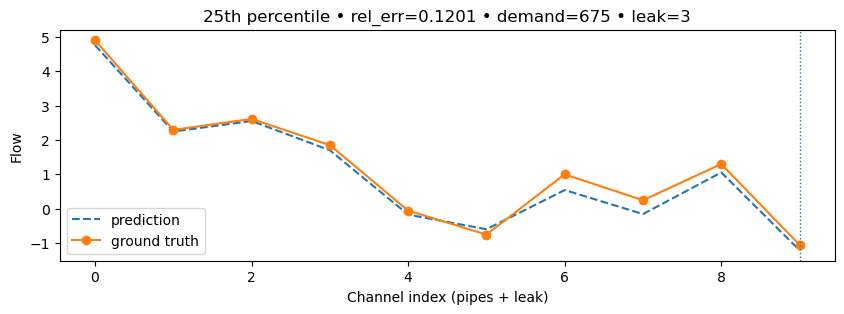

 50th percentile — rel_err=0.185272  (demand=604, leak=7)


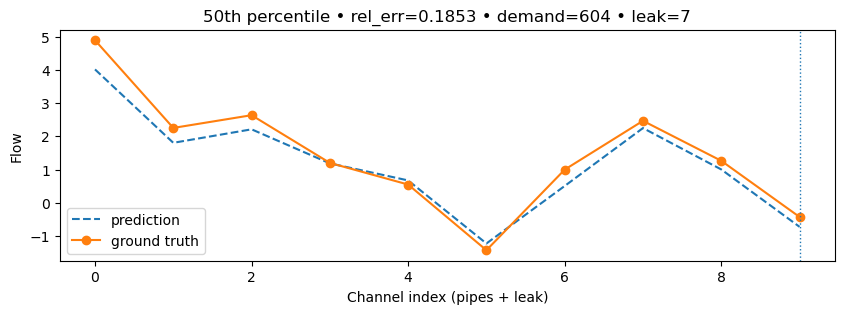

 75th percentile — rel_err=0.259303  (demand=312, leak=5)


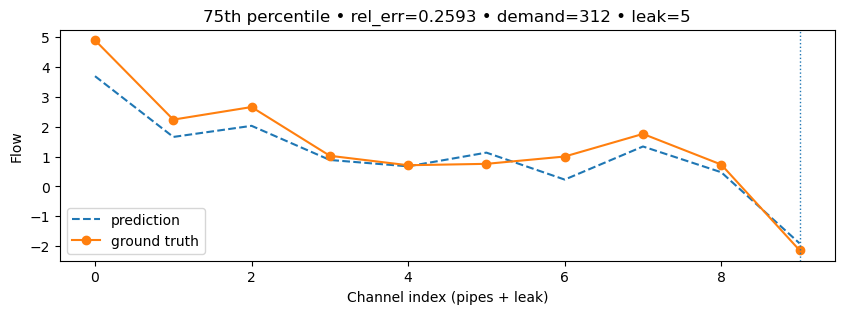

 95th percentile — rel_err=0.390527  (demand=132, leak=2)


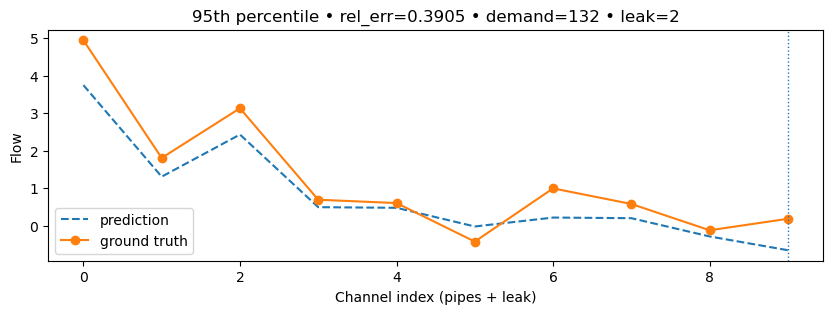

100th percentile — rel_err=0.743434  (demand=0, leak=0)


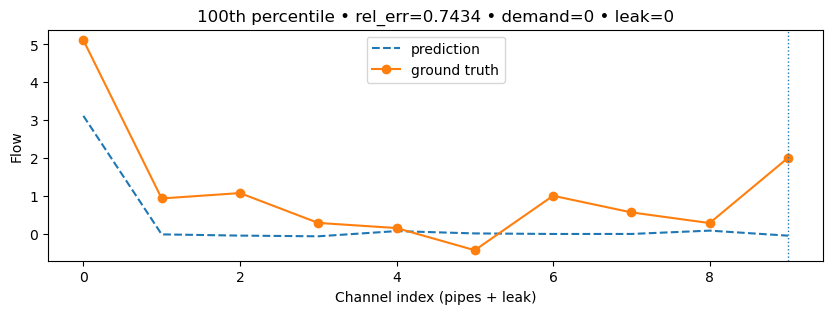

In [280]:
res = select_and_plot_percentiles(
    Q_pred=Q_full,
    Q_true=true,
    percentiles=(25, 50, 75, 95, 100),   # add 5 or 95, etc., if you want
    leak_channel=-1,
    outdir="pipe_eval_samples",      # omit or set None if you don't want files saved
    show=True
)

In [281]:
rel_err = (np.abs(Q_full - true)).mean(-1) / np.abs(true).mean(-1)
index = np.argmax(rel_err)
print(np.max(rel_err))

0.7434337941064993


Best loss: tensor(8.6412e-05, grad_fn=<AddBackward0>)


NameError: name 'color' is not defined

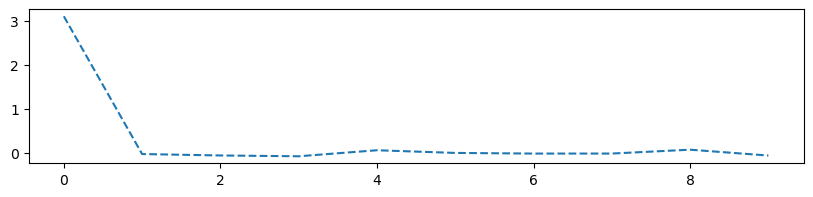

In [282]:
model.eval()

fig, axs = plt.subplots(1, 1, figsize=(10, 2), sharex=False)


worst_true = true.reshape(true.shape[0] * true.shape[1], *true.shape[2:])[index,...]
worst_Q = Q_full.reshape(true.shape[0] * true.shape[1], *true.shape[2:])[index,...]


axs.plot(np.arange(n_pipes+1), worst_Q, '--', alpha=1.0)  # Store the Line2D objects
axs.plot(np.arange(n_pipes+1), worst_true, '-o', color=color, alpha=1.0)

Best loss: tensor(7.0562e-05, grad_fn=<AddBackward0>)
0.24022453442275568


IndexError: index 8991 is out of bounds for axis 0 with size 1000

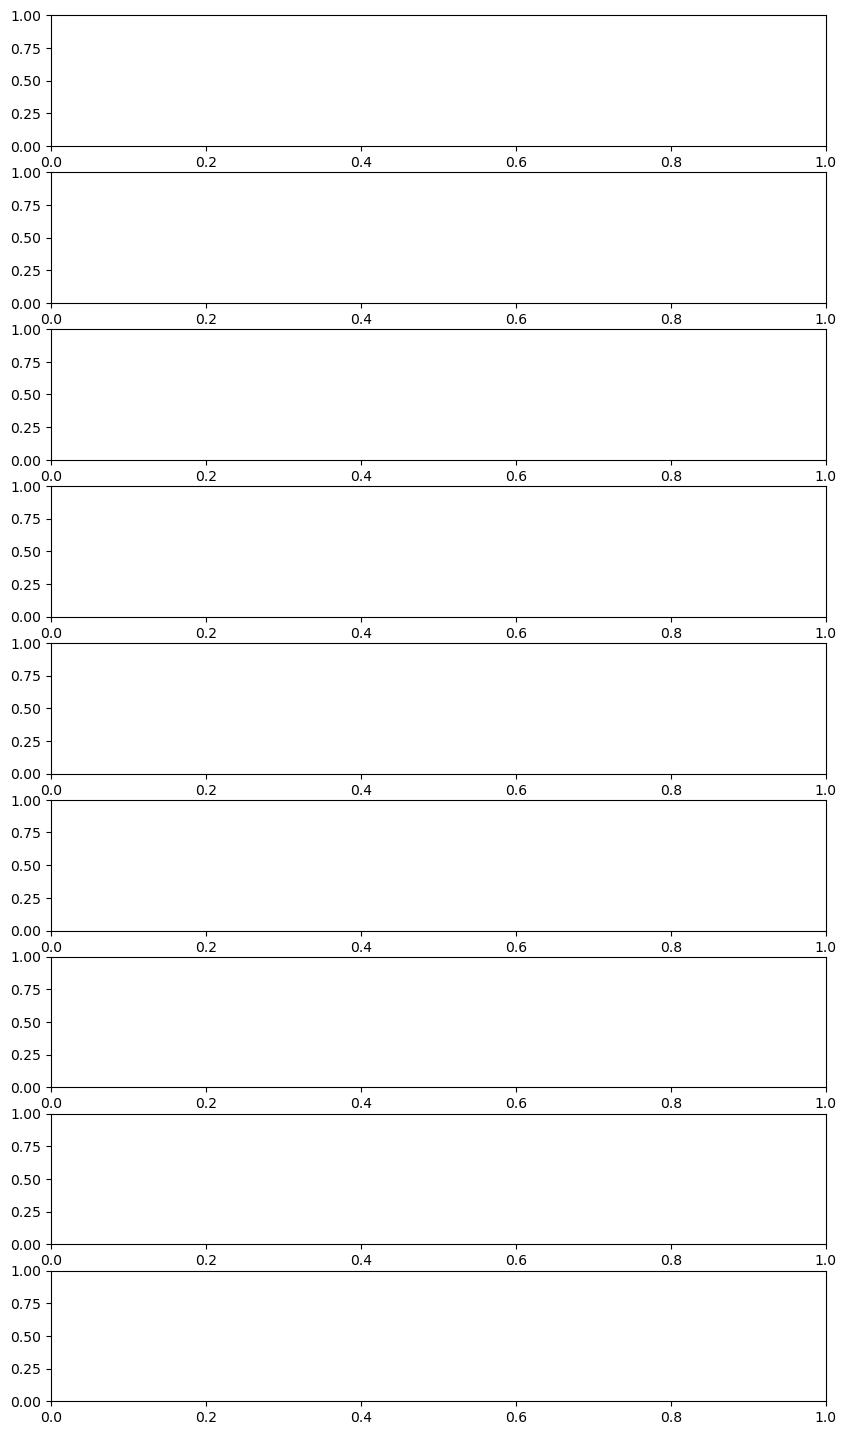

In [ ]:
model.eval()
#true_df = flow_df.drop(columns=['Leak Area'])

fig, axs = plt.subplots(n_pipes, 1, figsize=(10, 2 * n_pipes), sharex=False)
axs = np.atleast_1d(axs)

ind = np.argsort(wn.pipe_name_list, axis=0)

#no_leak = flow_df.drop(columns=['Leak Area', 'Leak Node ID']).iloc[0].to_numpy()

for i in range(n_pipes):
    
    x_ticks = ['']*(n_pipes+1)
    x_ticks[i+1] =  pipe_names[i]+'_B'
    
    
    #no_leak[-1] = no_leak[i] 

    #Q = Q_full[i, :].detach().numpy().squeeze()
    #Q = np.concatenate((Q[:n_pipes], Q[None,n_pipes+i]))
    
    #true = flow_df[flow_df['Leak Node ID'] == f'LEAK-{i}'].drop(columns=['Leak Node ID', 'Leak Area']).to_numpy()
    
    worst_true = true.reshape(true.shape[0] * true.shape[1], *true.shape[2:])[index,...]
    worst_Q = Q_full.reshape(true.shape[0] * true.shape[1], *true.shape[2:])[index,...]
    
    print(((np.abs(Q_big - actual_big)).mean(-1) / np.abs(actual_big).mean(-1)).mean() )


    actual = true[index,i,...]
    Q = Q_full[index,i,...]
    
    
    # axs[i].plot(np.arange(n_pipes+1), Q, '--', alpha=1.0)  # Store the Line2D objects
    # axs[i].plot(np.arange(n_pipes+1), actual, '-', alpha=1.0)
    
    
    # pipe_names = list(flow_df.columns[2:])
    # pipe_names[-1] = pipe_names[i]+'_B'
    
    # order = np.argsort(pipe_names)
    
    # pipe_names = np.sort(pipe_names)
    
    
    # lines = axs[i].plot(np.arange(n_pipes+1), Q[order], '--', alpha=1.0)  # Store the Line2D objects
    # #axs[i].plot(np.arange(n_pipes+1), no_leak[order], '-o', alpha=1.0, color='red')
    
    # for j, line in enumerate(lines):
    #     color = line.get_color() 
    #     axs[i].plot(np.arange(n_pipes+1), actual[j,order], '-o', color=color, alpha=1.0)
    #     axs[i].set_title(f'LEAK-{i}')
    #     axs[i].set_xticks(np.arange(n_pipes+1))  
    #     axs[i].set_xticklabels(x_ticks)
        

        
axs[-1].set_xlabel("Leak Node ID")
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [ ]:
# display(q_df)
# display(true_df)
# display(error_df)

In [ ]:
# def get_upstream_idx(G, start_node, visited=None):
#     if visited is None:
#         visited = set()

#     if start_node in visited:
#         return []

#     visited.add(start_node)
#     upstream_idx = []

#     for n in G.predecessors(start_node):
#         idx = np.where((edgelist == [n, start_node]).sum(-1) == 2)[0].item()
#         upstream_idx.append(idx)
#         upstream_idx += get_upstream_idx(G, n, visited)

#     return upstream_idx

# U = torch.zeros(2*n_pipes, n_pipes)
# for i in range(n_pipes):
#     print(f'Doing LEAK-{i}...')
#     affected = get_upstream_idx(wn.to_graph(), f'LEAK-{i}')
#     U[affected, i] = 1
#     print(f'LEAK-{i} done!')

In [ ]:
def d_leak(a, H):
    d = Cd * a * torch.sqrt(2 * g * relu(H))
    return d
    
def hL(q):
    return torch.sign(q) * 10.667 * model_params['C']**(-1.852) * model_params['d']**(-4.871) * model_params['L'] * torch.abs(q)**(1.852)

def mv(M, v):
    return (M @ v.T).T
    
mse = lambda x : (x**2).mean()


demand = torch.zeros(1, model_params['A0'].shape[0])
demand[:,model_params['demand_idx']] = model_params['D']


idx = torch.tensor([[-1]])
batch_idx = torch.arange(1).unsqueeze(1).expand_as(idx)

areas = torch.zeros((1, n_pipes))
areas[batch_idx,idx] = leak_areas[0] 


A0 = model_params['A0']

B = model_params['B']
S = model_params['S']

M = model_params['M']

inv = model_params['inv']

supply = B @ S

hL = hL(Q_torch)    
H = mv(inv, supply - hL)

print(Q_torch.shape)
 
mse(mv(A0, Q_torch) - demand - d_leak(mv(M, areas), H))

KeyError: 'D'